# Exemple-CASSIOPE-FAI
***

**Tutoriel :** Ce tutoriel explique comment visualiser les données de la caméra FAI.    
**Mission et Instrument :** FAI (Fast Auroral Imager) sur CASSIOPE      
**Objectif astronomique :** Émissions aurorales    
**Outil principal :** Script Python3     
**Niveau du tutoriel :** Intermédiaire 

Le script présenté est un exemple de visualisation des photos prises par l'instrument FAI (Fast Auroral Imager) qui mesure les émissions d'aurores boréales. L'Université de Calgary fournit déjà des visualisation des données du FAI via [l'accès HTTP](https://epop-data.phys.ucalgary.ca/) et le [eDex Web](https://edex.phys.ucalgary.ca/#).

Dans ce tutoriel, on va apprendre comment visualiser les photos du FAI autrement. Les données ont été extraites avec le [eDex Web](https://edex.phys.ucalgary.ca/#) de l'Université de Calgary.

## Bibliothèque

Le script qui suit utilise

* *numpy* : opération mathématique et array multidimentionnel
* *h5py* : ouverture de fichier .h5
* *pandas* : structure de dataframe
* *matplotlib* : tracer des figures
* *basemap* : tracer des cartes
* *datetime* : manipuler des variables de temps
* *re* : faire de la recherche textuelle
* *os* : faire de la recherche dans le système de l'utilisateur

## Introduction

Les données des photos prises par le FAI sont stockées sous le format .h5 (HDF5). Voici un court script pour ouvrir, accéder et visualiser les données. Commençons par extraire les données d'un fichier .h5.

In [2]:
import numpy as np
import h5py
import pandas as pd

file = "FAI_lv1_IR_20190501_150819_150819_5.0.0.h5" # répertoire et nom du fichier

with h5py.File(file, 'r') as f:
        lat = np.array(f.get('Pixel_Latitudes')) # Les latitudes de l'image
        lon = np.array(f.get('Pixel_Longitudes')) # Les longitudes de l'image
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys) # Les attributs de l'image
        image = np.array(f.get('FAI_Image')) # Les données de luminosité de l'image

Puisque les données de latitude et de longitude sont utilisées pour une photo, la dernière ligne et la dernière colonne servent à indiquer le coin en bas à droite de l'image, on peut donc les retirer pour notre visualisation.

In [3]:
lat = np.delete(lat,lat.shape[0]-1,0) 
lat = np.delete(lat,lat.shape[1]-1,1)
lon = np.delete(lon,lon.shape[0]-1,0) 
lon = np.delete(lon,lon.shape[1]-1,1)

Visualiser la photo du FAI est assez facile en utilisant la bibliothèque Matplotlib. On a aussi accès à une liste d'attributs opérationnels.

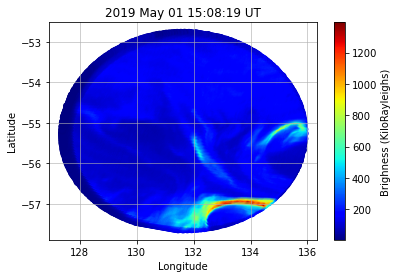

                                                                               0
Attitude Determination Mode                                                    4
CCD Temperature (°C)                                                    -19.8867
Camera Mode                                                      High Resolution
Camera Source                                                  NIR (650-1100 nm)
DN to Rayleigh Conversion Factor (R/DN/s)                                  104.0
Exposure Time (s)                                                            0.1
Magnetic Latitude (°)                                                 -63.320742
Magnetic Local Time                                                     0.398105
Magnetic Longitude (°)                                               -147.720346
Pitch (°)                                                               -0.25787
Roll (°)                                                               -0.905766
S/C Altitude (km)           

In [4]:
import matplotlib.pyplot as plt

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image/1000,cmap='jet')
plt.colorbar(label='Brighness (KiloRayleighs)')
plt.show()
print(attributes)

On remarque la présence d'un halo autour de l'image. Pour en savoir plus sur cet halo, il y a plus d'information dans le [rapport sur le FAI](https://epop.phys.ucalgary.ca/wp-content/uploads/2021/05/R1-FAI-Characterization-Report.pdf) à la section B.14.f. Pour améliorer l'esthétisme, nous allons retirer ce halo en appliquant un filtre aux données. Ensuite, pour complexifier les choses, nous ferons une figure où on voit l'évolution des photos du FAI au traver du temps (quelques secondes).

## Retirer le halo

Les photos prises par le FAI ont une forme elliptique (généralement plus large que haute). L'équation d'une ellipse est

$$\frac{(x-h)^2}{a^2}+\frac{(y-k)^2}{b^2}=1$$
où
* $(h,k)$ est le centre de l'ellipse ;
* $a$ est la demi-mesure de l'axe horizontal ;
* $b$ est la demi-mesure de l'axe vertical.

Nous utiliserons cette équation pour retirer le halo. Voici son implémentation en python.

In [5]:
def ellipse(x,y,a,b,h,k):
    return( (((x-h)**2) / a**2) + (((y-k)**2) / b**2 ))

Par exemple, avec l'image plus haut, on peut estimer les paramètres

* $(h,k) = (131.8,-55.2)$
* $a = 4.1$
* $b = 2.3$

pour une ellipse qui n'inclut pas le halo.

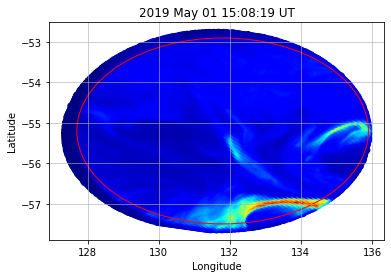

In [6]:
from matplotlib.patches import Ellipse

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image,cmap='jet')
ax = plt.gca()
ax.add_patch(Ellipse((131.8,-55.2), 4.1*2, 2.3*2,ec='red',fc='None'))
plt.show()

La fonction qui suit retire le halo, c'est-à-dire qu'elle annule ce qui est à l'extérieur de la ligne rouge. La plupart du temps, le halo représente environ 5% du contour de l'image, donc on garde 95% de l'image. Il est possible de modifier ce paramètre et de le mettre à 100% si on ne veut pas retirer le halo.

In [7]:
def ellipseFilter(lon,lat,pct_halo):
    
    # Déterminer les paramètres de la fonction ellipse (sans le halo)
    a = (np.nanmax(lon)-lon[139][127])*pct_halo
    b = (np.nanmax(lat)-lat[139][127])*pct_halo
    h = lon[139][127]
    k = lat[139][127]
    
    # Pour tous les couples lat/lon, vérifier s'ils forment le halo 
    # (c'est-à-dire si l'équation d'ellipse est plus grande que 1)
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
                if ellipse(lon[i][j],lat[i][j],a,b,h,k) > 1 :
                    lon[i][j] = np.NAN
                    lat[i][j] = np.NAN            
    
    return(lon,lat)

Voici le résultat final.

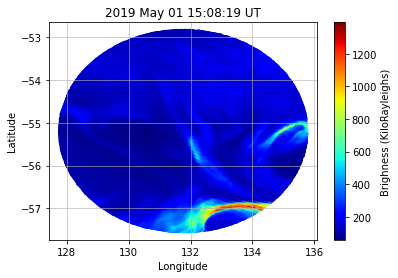

In [8]:
lon, lat = ellipseFilter(lon,lat,0.95)

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image/1000,cmap='jet')
plt.colorbar(label='Brighness (KiloRayleighs)')
plt.show()

## L'évolution des photos dans le temps

L'Université de Calgary fournit déjà des vidéos *mp4* qui permettent de visualiser les images prises par le FAI. Le FAI prenant une image par seconde, il s'agit de belle animation intéressante. Cependant, cela rend difficile de regarder comment se comporte un point précis. Le reste du tutoriel servira à visualiser cette situation.

La fonction prend en paramètres le répertoire et la liste des fichiers à visualiser et le pourcentage de l'image à garder (défaut 95%).

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.basemap import Basemap

from datetime import datetime as dt
import re
import os

# Créer la figure composée de 15 images du FAI et de la trajectoire du satellite sur un globe
# directory : répertoire où les fichiers .h5 sont
# filelist : liste des fichiers à imager (string) (15 fichiers)
def createPlot(directory,filelist,pct_halo=0.95):
    
    # Créer la figure
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize = [9,10], sharex=True, sharey=True)

    # Graduations, couleurs et titres
    norm, mycmap, conversion = plotSetUp(directory+filelist[7], axs, fig)
    
    # Garder en mémoire la trajectoire du satellite
    xpos=list()
    ypos=list()

    # Ajouter l'image pour tous les fichiers
    for index, file in enumerate(filelist) :
       
        filename = directory+file
        
        # Extraire le temps pour le titre
        match = re.search(r'(\d+)_(\d+)', file)
        d = dt.strptime(match.group(0), '%Y%m%d_%H%M%S')
        axs[index//4][index%4].set_title(d.time())
        
        # Ouvrir le fichier
        with h5py.File(filename, 'r') as f:
            image = np.array(f.get('FAI_Image'))/conversion
            lat = np.array(f.get('Pixel_Latitudes'))
            lon = np.array(f.get('Pixel_Longitudes'))
        
        # Ajustements pour l'image (retirer la dernière ligne et colonne des
        # latitudes et longitudes)
        lat = np.delete(lat,lat.shape[0]-1,0) 
        lat = np.delete(lat,lat.shape[1]-1,1) 
        
        lon = np.delete(lon,lon.shape[0]-1,0) 
        lon = np.delete(lon,lon.shape[1]-1,1)
        
        # Retirer le halo
        lon, lat = ellipseFilter(lon,lat,pct_halo)
        
        # Stocker le positionnement du satellite (le centre de l'image)
        xpos.append(lon[139][127])
        ypos.append(lat[139][127])
        
        # Tracer l'image, ajuster les axes et ajouter grille
        axs[index//4][index%4].scatter(lon,lat,c=image,cmap=mycmap,norm=norm)
        axs[index//4][index%4].xaxis.set_minor_locator(AutoMinorLocator(2))
        axs[index//4][index%4].tick_params(direction='in',length=8,width=1.8,which='both')
        axs[index//4][index%4].grid(color='#7CB9E8', ls='dotted',which='both',alpha=0.7)
    
    # Ajouter une carte avec la trajectoire de CASSIOPE
    gs = axs[3][3].get_gridspec()
    axs[3][3].remove()
    mapax = fig.add_subplot(gs[3,3])
    
    m = Basemap(projection='ortho',lon_0 = xpos[7], lat_0 = ypos[7], ax=mapax)
    
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.25)
    m.fillcontinents(color='white',lake_color='#84CBD7')
    m.drawmapboundary(fill_color='#84CBD7')

    m.plot(xpos,ypos,latlon=True,linewidth=3,color='red')
    
    return

Une partie de la mise en page a été implémentée dans une fonction distincte.

In [10]:
# Fixer les graduations des graphes, création des couleurs utilisées et titres
# file : les graphes seront centrées selon ce fichier
# ax : axe utilisé pour fixer les graduations
# fig : la figure à modifier
def plotSetUp(file,axs,fig):
    
    # Mise en page
    plt.subplots_adjust(wspace=0.1, hspace=0.175,bottom=0.17,top=0.93)
    plt.setp(axs,facecolor="lightgrey")
    
    # Ajouter les titres
    # Le titre de la figure
    start_time = re.search(r'(\d+)_(\d+)', filelist[0])
    start_time = dt.strptime(start_time.group(0), '%Y%m%d_%H%M%S')
    end_time = re.search(r'(\d+)_(\d+)', filelist[14])
    end_time = dt.strptime(end_time.group(0), '%Y%m%d_%H%M%S')
    title = start_time.strftime("%Y %b %d %H:%M:%S") + ' - ' + end_time.strftime("%H:%M:%S") + ' UT'
    fig.suptitle(title, size=16)
    
    # Les autres titres
    fig.text(0.515, 0.137, 'Longitude (Degrés)', ha='center', va='center',size=12)
    fig.text(0.06, 0.55, 'Latitude (Degrés)', ha='center', va='center', rotation='vertical',size=12)
    fig.text(0.5, 0.05, 'Brightness (Data Unit)', ha='center', va='center',size=12)
    
    # Ouvrir le fichier et extraire les latitudes, les longitudes, 
    # l'image et la conversion en Data Unit
    with h5py.File(file, 'r') as f:
        lat = np.array(f.get('Pixel_Latitudes'))
        lon = np.array(f.get('Pixel_Longitudes'))
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        image = np.array(f.get('FAI_Image'))/conversion
    
    # La norme et les couleurs pour colorer les images du FAI
    norm = colors.Normalize(vmin=0,vmax=np.nanmax(image)*0.7)
    cmap = plt.get_cmap('gist_rainbow_r')
    mycmap = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.12, 0.97)))
    
    # Ajout de la barre de couleurs
    axbar = fig.add_axes([0.2, 0.09, 0.6, 0.02])
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=mycmap), cax=axbar, orientation="horizontal")
    
    # Définir les graduations pour toutes les images
    gaplat = (np.nanmax(lat)-np.nanmin(lat))*1/10
    gaplon = (np.nanmax(lon)-np.nanmin(lon))*1/10
    axs[1][3].set_ylim(np.nanmin(lat)-gaplat,np.nanmax(lat)+gaplat)
    axs[1][3].set_xlim(np.nanmin(lon)-gaplon,np.nanmax(lon)+gaplon)
    
    axs[2][3].tick_params(labelbottom=True)
    
    return(norm,mycmap,conversion)

C'est le moment de tester notre fonction. Nous avons qu'à fournir le répertoire où les fichiers se situent, la position du premier fichier à tracer dans la liste des fichiers et l'intervalle de temps (en seconde) entre les images. On peut aussi choisir le pourcentage de l'image que l'on désire garder (pour retirer le halo).

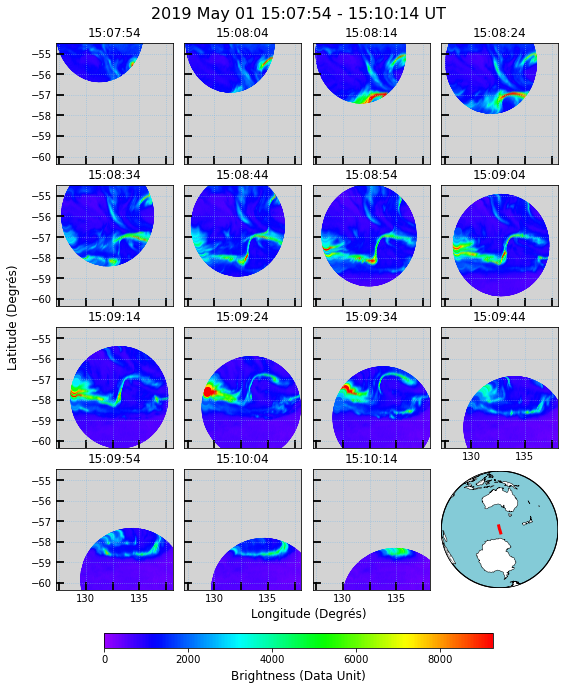

In [11]:
directory = "FAI_lv1_h5_20190501_150534_151306_5.0.0\\" # # Répertoire où sont les fichiers .h5
firstfile = 140 # le n-ieme fichier dans le répertoire
seconds = 10 # Temps entre les images
pct_halo = 0.95 # Pourcentage de l'image à garder
filelist = os.listdir(directory)[firstfile::seconds][0:15] # Liste des fichiers pour créer la figure

createPlot(directory,filelist)

Dans cette image, l'axe des x et des y sont les mêmes pour toutes les figures. On remarque aussi qu'il y a 10 secondes entre chaque photo. En bas à droite, il s'agit de la trajectoire de CASSIOPE à ce moment. Voici un autre exemple pour finaliser ce tutoriel.

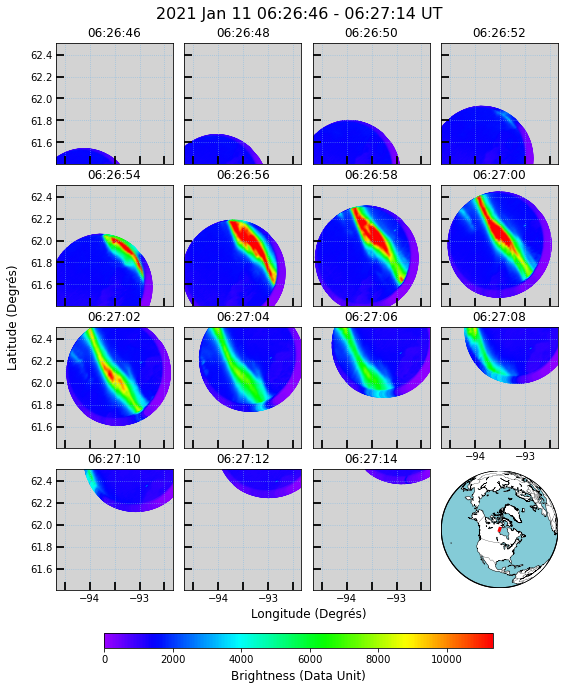

In [12]:
directory = "FAI_lv1_h5_20210111_062314_063145_5.0.0\\" # Répertoire où sont les fichiers .h5 pour faire la figure
firstfile = 212 # le n-ieme fichier dans le répertoire
seconds = 2 # Temps entre les images
pct_halo = 1 # Pourcentage de l'image à garder
filelist = os.listdir(directory)[firstfile::seconds][0:15] # Liste des fichiers pour créer la figure

createPlot(directory,filelist,pct_halo)